<a href="https://colab.research.google.com/github/gustavohroos/treinamento-h2ia/blob/main/busca-tabu/busca_tabu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema da mochila usando Busca Tabu
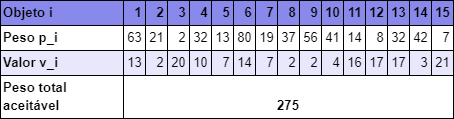

In [491]:
import numpy as np
import pandas as pd

### Dataframe para armazenar os objetos, o qual será usado para preencher a mochila passando o array como máscara

In [492]:
MAX_WEIGHT = 275
weights = np.array([63, 21, 2, 32, 13, 80, 19, 37, 56, 41, 14, 8, 32, 42, 7])
values = np.array([13, 2, 20, 10, 7, 14, 7, 2, 2, 4, 16, 17, 17, 3, 21])
objects = pd.DataFrame({'weight': weights, 'value': values})
objects

,weight,value
0,63,13
1,21,2
2,2,20
3,32,10
4,13,7
5,80,14
6,19,7
7,37,2
8,56,2
9,41,4


In [493]:
from typing import List
from __future__ import annotations
from copy import deepcopy

def generate_array() -> np.ndarray:
    '''
    Função para gerar array aleatório válido, isto é, com peso total abaixo do máximo
    '''
    while True:
        array = np.random.randint(2, size=15)
        if objects[pd.Series(data=(array == 1))]['weight'].sum() <= MAX_WEIGHT:
            return array

class Knapsack:
    def __init__(self, 
                 array: np.ndarray = generate_array()) -> None:
        self.array = array
        self.weight = None
        self.value = None
        self.update_items()
        self.swap = None

    def item_swap(self, other: Knapsack) -> None:
        '''
        Identifica e armazena qual o item foi modificado para que chegasse nesta
        instância
        '''
        if self.array.size > 0 and other.array.size > 0:
            self.swap = np.where(np.equal(self.array, other.array) == False)[0][0]
    
    def update_items(self, objects: pd.DataFrame = objects) -> None:
        '''
        Atualiza/define o peso e o valor da mochila, a partir do DataFrame dos
        objetos, utilizando o array como máscara
        '''
        self.weight = objects[pd.Series(data=(self.array == 1))]['weight'].sum()
        self.value = objects[pd.Series(data=(self.array == 1))]['value'].sum()
        
    def generate_neighbors(self, tabu_list: List[int]) -> List[Knapsack]:
        '''
        Gera os vizinhos possíveis, modificando um item de cada vez e checando 
        se o item pode ser modificado antes de retornar uma lista com todos vizinhos
        permitidos
        '''
        neighborhood = []

        for i in range(15):
            neighbor = deepcopy(self)
            if neighbor.array[i] == 0:
                neighbor.array[i] = 1
                neighbor.update_items()
            else:
                neighbor.array[i] = 0
                neighbor.update_items()
            if neighbor.weight <= MAX_WEIGHT:
                neighbor.item_swap(self)
                if neighbor.swap not in tabu_list:
                    neighborhood.append(neighbor)
        return neighborhood

    def best_neighbor(self, tabu_list: List[int]) -> Knapsack:
        '''
        Escolhe o melhor vizinho possível da lista de vizinhos possíveis
        '''
        neighborhood = self.generate_neighbors(tabu_list)
        best = neighborhood[0]
        for neighbor in neighborhood:
            if neighbor.value > best.value:
                best = deepcopy(neighbor)
                best.item_swap(self)
        return best

    def __gt__(self, other: Knapsack) -> bool:
        '''
        Função para checar se uma mochila é melhor que a outra usando seu valor
        como critério
        '''
        return self.value > other.value

    def __repr__(self) -> str:
        '''
        Função que retorna uma string representando a mochila com seu peso, valor
        e os itens num array binário
        '''
        return f'\n{"=-"*16}\nWeight: {self.weight}\nValue: {self.value}\n{self.array}\n{"=-"*16}'

In [494]:
MAX_ITERATIONS = 50
TABU_LIST_SIZE = 5

def tabu_search(start_knap: Knapsack = Knapsack(), 
                tabu_list_size: int = TABU_LIST_SIZE, 
                max_iterations: int = MAX_ITERATIONS) -> None:
    '''
    Executa busca tabu
    '''
    tabu_list = []
    iterations = best_iteration = 0
    best_solution = current_solution = start_knap
    print(f'Start solution: {best_solution}\n')
    total = 0

    while iterations - best_iteration <= max_iterations:
        iterations += 1
        current_solution = current_solution.best_neighbor(tabu_list)
        tabu_list.append(current_solution.swap)
        if len(tabu_list) >= tabu_list_size:
            tabu_list.pop(0)
        if current_solution > best_solution:
            del best_solution
            best_solution = current_solution
            best_iteration = iterations
    print(f'Best solution found: {best_solution}')

%time tabu_search()

Start solution: 
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Weight: 239
Value: 87
[1 1 1 1 0 0 1 0 1 0 1 0 1 0 0]
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

Best solution found: 
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Weight: 270
Value: 142
[1 0 1 1 1 1 1 0 0 0 1 1 1 0 1]
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
CPU times: user 909 ms, sys: 57.5 ms, total: 967 ms
Wall time: 897 ms


## Após muita luta
Depois de muito quebrar a cabeça, creio ter chegado na melhor versão do algoritmo, que anteriormente demorava cerca de 35 segundos para chegar num resultado, agora leva em média 2 segundos e <del>quase</del> sempre chega na solução ótima global. <br>
Alterei o modo como a lista tabu funciona. Anteriormente, armazenava as instâncias de mochila, porém percebi que a busca entrava em looping. Portanto, o algoritmo passou a armazenar o item que foi modificado, fazendo com que ele não possa ser modificado novamente durante os turnos definidos para a lista tabu.